In [2]:
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error, adjusted_rand_score
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from ipywidgets import FloatProgress
from IPython.display import display
%matplotlib inline

In [26]:
def fit_scatter(y_true, y_pred,filename=None,title=None):
    assert y_true.shape == y_pred.shape
    fig, ax = plt.subplots()
    m, b = np.polyfit(y_true, y_pred, 1)
    ax.scatter(y_true, y_pred, marker='o',color='b',label='RP genes')
    ax.plot(y_true, m*y_true + b,'--', color='g',lw=2,label='Pearson\'s R: {0:.3f}'.format(np.corrcoef(y_true, y_pred)[0][1]))
    ax.set_ylim(ymin=0,ymax=1)
    ax.legend(loc=4)
    #ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4,color='w')
    ax.set_xlabel('Observed AUC')
    ax.set_ylabel('Predicted AUC')
    if title is not None:
        ax.set_title('{}'.format(title))
    if filename is not None:
        fig.savefig('images/{}.pdf',filename)

In [27]:
def fit_scatter_nrp(y_true, y_pred,filename=None,title=None):
    assert y_true.shape == y_pred.shape
    fig, ax = plt.subplots()
    m, b = np.polyfit(y_true, y_pred, 1)
    ax.scatter(y_true, y_pred, marker='o',color='r',label='nonRP genes')
    ax.plot(y_true, m*y_true + b,'--', color='g',lw=2,label='Pearson\'s R: {0:.3f}'.format(np.corrcoef(y_true, y_pred)[0][1]))
    ax.set_ylim(ymin=0,ymax=1)
    ax.legend(loc=4)
    #ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4,color='w')
    ax.set_xlabel('Observed AUC')
    ax.set_ylabel('Predicted AUC')
    if title is not None:
        ax.set_title('{}'.format(title))
    if filename is not None:
        fig.savefig('images/{}.pdf',filename)

In [17]:
def fit_scatter_multi(y_true1,y_true2, y_pred1, y_pred2,filename=None,title=None):
#     assert y_true.shape == y_pred.shape
    fig, ax = plt.subplots()
    plt.style.use('ggplot')
    ax.scatter(y_true1, y_pred1,color='blue',label='RP genes')
    ax.scatter(y_true2, y_pred2, color='red',label='nonRP genes')
    
    y_true = np.concatenate((y_true1,y_true2),axis=0)
    y_pred = np.concatenate((y_pred1,y_pred2),axis=0)
    
    m, b = np.polyfit(y_true, y_pred, 1)
    ax.plot(y_true, m*y_true + b,linestyle='dashed', color='g',lw=2,label='Pearson\'s R: {0:.3f}'.format(np.corrcoef(y_true, y_pred)[0][1]))
    ax.set_ylim(ymin=0,ymax=1)
    ax.legend(loc=4)
    #ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4,color='w')
    ax.set_xlabel('Observed AUC')
    ax.set_ylabel('Predicted AUC')
    if title is not None:
        ax.set_title('{}'.format(title))
    if filename is not None:
        plt.savefig('images/{}.pdf'.format(filename))

In [6]:
def plot_importance(feature_importance,names,filename=None):
    plt.figure(figsize=(6, 8))
    plt.style.use('ggplot')
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center',color='b')
    plt.yticks(pos, names[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('RF variable importance')
    plt.tight_layout()
    if filename is not None:
        plt.savefig('images/{}.pdf'.format(filename))
    plt.show()
    

In [7]:
def plot_imp(feature_importance,names):
    print(names)
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    fig2, ax2 = plt.subplots(figsize=(10,15))
    ax2.barh(pos, feature_importance[sorted_idx], align='center')
    ax2.set_yticks(pos, names[sorted_idx])
    ax2.set_xlabel('RF feature importance')

In [8]:
def print_stats(true,predictions):
    print('Coefficient of determination R^2: {}'.format(r2_score(true, predictions)))
    print('Mean squared error:               {}'.format(mean_squared_error(true, predictions)))
    print('Mean absolute error:              {}'.format(mean_absolute_error(true, predictions)))
    print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(true, predictions))))
    print('Correlation Coefficient:          {}'.format(np.corrcoef(true, predictions)[0][1]))

In [9]:
def get_best_settings(results_1,results_2):
    best_result_1 = results_1[0][0][0]
    best_result_2 = results_2[0][0][0]
    best_difference = results_2[0][0][0] - results_1[0][0][0]

    best_i_1=0
    best_j_1=0
    best_k_1=0

    best_i_2=0
    best_j_2=0
    best_k_2=0

    best_i_3=0
    best_j_3=0
    best_k_3=0
    

    mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
    md = [5,7,10,12,15,18,20]
    n_est = [10,20,30,40,50,60,80,90,100,120,140,160]
    
    for i in range(len(mxf)):
        for j in range(len(md)):
            for k in range(len(n_est)):
                if best_result_1 < results_1[i][j][k]:
                    best_result_1 = results_1[i][j][k]
                    best_i_1=i
                    best_j_1=j
                    best_k_1=k
                if best_result_2 < results_2[i][j][k]:
                    best_result_2 = results_2[i][j][k]
                    best_i_2=i
                    best_j_2=j
                    best_k_2=k
                if best_difference < results_2[i][j][k] - results_1[i][j][k]:
                    best_difference = results_2[i][j][k] - results_1[i][j][k]
                    best_i_3=i
                    best_j_3=j
                    best_k_3=k

#     print('{} {} {} : {}'.format(best_i_1,best_j_1,best_k_1,best_result_1))
#     print('{} {} {} : {}'.format(best_i_2,best_j_2,best_k_2,best_result_2))
#     print('{} {} {} : {}'.format(best_i_3,best_j_3,best_k_3,best_difference))

    print('Normal best: {} | max_features: {}; max_depth: {}; n_estimators: {};'.format(best_result_1,mxf[best_i_1],md[best_j_1],n_est[best_k_1]))
    print('Extended best: {} | max_features: {}; max_depth: {}; n_estimators: {};'.format(best_result_2,mxf[best_i_2],md[best_j_2],n_est[best_k_2]))
    print('Best difference: {} | max_features: {}; max_depth: {}; n_estimators: {};'.format(best_difference,mxf[best_i_3],md[best_j_3],n_est[best_k_3]))
    
    return mxf[best_i_1],md[best_j_1],n_est[best_k_1],mxf[best_i_2],md[best_j_2],n_est[best_k_2]

In [10]:
data_path = os.path.join(os.getcwd(), 'datasets', 'features.csv')
data_path_rp = os.path.join(os.getcwd(), 'datasets', 'rp_features.csv')
data_path_nrp = os.path.join(os.getcwd(), 'datasets', 'nrp_features.csv')

data_path_extended = os.path.join(os.getcwd(), 'datasets', 'extended_features.csv')
data_path_rp_extended = os.path.join(os.getcwd(), 'datasets', 'rp_extended_features.csv')
data_path_nrp_extended = os.path.join(os.getcwd(), 'datasets', 'nrp_extended_features.csv')

data_path_cut = os.path.join(os.getcwd(), 'datasets', 'features_cut.csv')
data_path_extended_cut = os.path.join(os.getcwd(), 'datasets', 'extended_features_cut.csv')

data_path_rp_cut = os.path.join(os.getcwd(), 'datasets', 'rp_features_cut.csv')
data_path_nrp_cut = os.path.join(os.getcwd(), 'datasets', 'nrp_features_cut.csv')
data_path_rp_extended_cut = os.path.join(os.getcwd(), 'datasets', 'rp_extended_features_cut.csv')
data_path_nrp_extended_cut = os.path.join(os.getcwd(), 'datasets', 'nrp_extended_features_cut.csv')

gene_features = pd.read_csv(data_path, delimiter = ',')
rp_gene_features = pd.read_csv(data_path_rp, delimiter = ',')
nrp_gene_features = pd.read_csv(data_path_nrp, delimiter = ',')

extended_features = pd.read_csv(data_path_extended, delimiter = ',')
rp_extended_features = pd.read_csv(data_path_rp_extended, delimiter = ',')
nrp_extended_features = pd.read_csv(data_path_nrp_extended, delimiter = ',')

gene_features_cut = pd.read_csv(data_path_cut, delimiter = ',')
extended_features_cut = pd.read_csv(data_path_extended_cut, delimiter = ',')
rp_features_cut = pd.read_csv(data_path_rp_cut, delimiter = ',')
rp_extended_features_cut = pd.read_csv(data_path_rp_extended_cut, delimiter = ',')
nrp_features_cut = pd.read_csv(data_path_nrp_cut, delimiter = ',')
nrp_extended_features_cut = pd.read_csv(data_path_nrp_extended_cut, delimiter = ',')

print('Number of data points: {}. Number of attributes: {}'.format(gene_features.shape[0],gene_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(extended_features.shape[0],extended_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(rp_gene_features.shape[0],rp_gene_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(rp_extended_features.shape[0],rp_extended_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(nrp_gene_features.shape[0],nrp_gene_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(nrp_extended_features.shape[0],nrp_extended_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(gene_features_cut.shape[0],gene_features_cut.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(extended_features_cut.shape[0],extended_features_cut.shape[1]))

Number of data points: 117. Number of attributes: 101
Number of data points: 117. Number of attributes: 106
Number of data points: 84. Number of attributes: 101
Number of data points: 84. Number of attributes: 106
Number of data points: 33. Number of attributes: 101
Number of data points: 33. Number of attributes: 106
Number of data points: 117. Number of attributes: 21
Number of data points: 117. Number of attributes: 26


In [11]:
def get_data(dataset):
    
    X = gene_features.drop(['ORG', 'Gene','AUC'], axis=1)
    X_cut = gene_features_cut.drop(['ORG', 'Gene','AUC'], axis=1)
    y = gene_features['AUC']

    X_rp = rp_gene_features.drop(['ORG', 'Gene','AUC'], axis=1)
    X_rp_cut = rp_features_cut.drop(['ORG', 'Gene','AUC'], axis=1)
    y_rp = rp_gene_features['AUC']

    X_nrp = nrp_gene_features.drop(['ORG', 'Gene','AUC'], axis=1)
    X_nrp_cut = nrp_features_cut.drop(['ORG', 'Gene','AUC'], axis=1)
    y_nrp = nrp_gene_features['AUC']

    X_extended = extended_features.drop(['ORG', 'Gene','AUC'], axis=1)
    X_extended_cut = extended_features_cut.drop(['ORG', 'Gene','AUC'], axis=1)
    y_extended = extended_features['AUC']

    X_rp_extended = rp_extended_features.drop(['ORG', 'Gene','AUC'], axis=1)
    X_rp_extended_cut = rp_extended_features_cut.drop(['ORG', 'Gene','AUC'], axis=1)
    y_rp_extended = rp_extended_features['AUC']

    X_nrp_extended = nrp_extended_features.drop(['ORG', 'Gene','AUC'], axis=1)
    X_nrp_extended_cut = nrp_extended_features_cut.drop(['ORG', 'Gene','AUC'], axis=1)
    y_nrp_extended = nrp_extended_features['AUC']
    
    if dataset == 'full':
        return X,y,X_extended,y_extended
    elif dataset == 'rp':
        return X_rp,y_rp,X_rp_extended,y_rp_extended
    elif dataset == 'nrp':
        return X_nrp,y_nrp,X_nrp_extended,y_nrp_extended
    elif dataset == 'cut':
        return X_cut,y,X_extended_cut,y_extended
    elif dataset == 'rp_cut':
        return X_rp_cut,y_rp,X_rp_extended_cut,y_rp_extended
    elif dataset == 'nrp_cut':
        return X_nrp_cut,y_nrp,X_nrp_extended_cut,y_nrp_extended
    else:
        return None, None, None, None

In [12]:
def get_variable_names(dataset):
    
    if dataset == 'full':
        return gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, extended_features.drop(['ORG','Gene','AUC'], axis=1).columns
    elif dataset == 'cut':
        return gene_features_cut.drop(['ORG','Gene','AUC'], axis=1).columns, extended_features_cut.drop(['ORG','Gene','AUC'], axis=1).columns
    else:
        return None, None, None, None

In [13]:
kf = KFold(n_splits=5,shuffle=True,random_state=0)

In [14]:
X,y,X2,y2 = get_data('full')

lr1 = LinearRegression()
lr2 = LinearRegression()

predictions1 = cross_val_predict(lr1,X,y=y,cv=kf)
predictions2 = cross_val_predict(lr1,X2,y=y2,cv=kf)

print('Data')
print_stats(y,predictions1)
print('\n')
print('Extended Data')
print_stats(y2,predictions2)

Data
Coefficient of determination R^2: -7.218302015333855
Mean squared error:               0.428623354505183
Mean absolute error:              0.4702581683241454
Root mean squared error:          0.6546933285937646
Correlation Coefficient:          0.15630895126957536


Extended Data
Coefficient of determination R^2: -5.124905342449793
Mean squared error:               0.31944280813837916
Mean absolute error:              0.36293982808684455
Root mean squared error:          0.5651927176975825
Correlation Coefficient:          0.22134989868329735


In [30]:
X,y,X2,y2 = get_data('rp_full')

rfr1 = ExtraTreesRegressor(random_state=1337)
rfr2 = ExtraTreesRegressor(random_state=1337)

kf = KFold(n_splits=5,shuffle=True,random_state=0)
predictions_rfr1 = cross_val_predict(rfr1,X,y=y,cv=kf)
predictions_rfr2 = cross_val_predict(rfr2,X2,y=y2,cv=kf)

print('Data')
print_stats(y,predictions_rfr1)
print('\n')
print('Extended Data')
print_stats(y2,predictions_rfr2)

rfr1.fit(X,y)
rfr2.fit(X2,y2)

names,names2 = get_variable_names('full')
plot_importance(rfr1.feature_importances_,names,'foo')
plot_importance(rfr2.feature_importances_,names2,'foo')


Data
Coefficient of determination R^2: 0.14341293973709657
Mean squared error:               0.025373674642857145
Mean absolute error:              0.11562261904761906
Root mean squared error:          0.15929116310347272
Correlation Coefficient:          0.43478418511647643


Extended Data
Coefficient of determination R^2: 0.23026901848935022
Mean squared error:               0.02280083880952381
Mean absolute error:              0.10924285714285716
Root mean squared error:          0.15099946625575802
Correlation Coefficient:          0.49358104633453104


TypeError: plot_importance() missing 1 required positional argument: 'filename'

# Full Set

In [20]:
def best_RFs(results1,results2,dataset):
     
    X,y,X2,y2 = get_data(dataset)
    mxf1, md1, n_est1, mxf2, md2, n_est2 = get_best_settings(results1,results2)
    
    kf = KFold(n_splits=5,shuffle=True,random_state=0)
    
    rfr1 = ExtraTreesRegressor(n_estimators=n_est1, 
                                criterion='mse', 
                                max_features=mxf1, 
                                max_depth=md1, 
                                n_jobs=2,
                                random_state=1337)

    rfr2 = ExtraTreesRegressor(n_estimators=n_est2, 
                                criterion='mse', 
                                max_features=mxf2, 
                                max_depth=md2, 
                                n_jobs=2,
                                random_state=1337)

    predictions_rfr1 = cross_val_predict(rfr1,X,y=y,cv=kf)
    predictions_rfr2 = cross_val_predict(rfr2,X2,y=y2,cv=kf)

    print('Normal feature space')
    print_stats(y, predictions_rfr1)
    print('\n')
    print('Extended feature space')
    print_stats(y2, predictions_rfr2)
    print('-------------------------------------------------------\n')
         
    settings = 'max_features: {}; max_depth: {}; n_estimators: {};'.format(mxf1,md1,n_est1)
          
    rfr1.fit(X,y)
    fig, ax1 = plt.subplots(figsize=(20,6))
    xx = np.arange(len(rfr1.feature_importances_))
    ax1.bar(xx, rfr1.feature_importances_)
    ax1.set_xticks(xx)
    ax1.set_xticklabels(gene_features_cut.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
    ax1.set_title('Normal RF: {} -- {}'.format(settings,np.corrcoef(y, predictions_rfr1)[0][1]))

    settings = 'max_features: {}; max_depth: {}; n_estimators: {};'.format(mxf2,md2,n_est2)
    rfr2.fit(X2,y2)
    fig2, ax2 = plt.subplots(figsize=(20,6))
    xx = np.arange(len(rfr2.feature_importances_))
    ax2.bar(xx, rfr2.feature_importances_)
    ax2.set_xticks(xx)
    ax2.set_xticklabels(extended_features_cut.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
    ax2.set_title('Extended RF : {} -- {}'.format(settings,np.corrcoef(y2, predictions_rfr2)[0][1]))

In [21]:
X,y,X2,y2 = get_data('full')
print('echo')
mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
md = [5,7,10,12,15,18,20]
n_est = [10,20,30,40,50,60,80,90,100,120,140,160]

results_1_full = np.zeros((len(mxf),len(md),len(n_est)))
results_2_full = np.zeros((len(mxf),len(md),len(n_est)))

f = FloatProgress(min=0, max=(len(mxf)*len(md)*len(n_est)))
display(f)


i = 0
for max_features in mxf:
    j = 0
    for max_depth in md:
        k = 0
        for n_estimators in n_est:            
            
            kf = KFold(n_splits=5,shuffle=True,random_state=0)

            rfr1 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            rfr2 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            predictions_rfr1 = cross_val_predict(rfr1,X=X,y=y,cv=kf)
            predictions_rfr2 = cross_val_predict(rfr2,X=X2,y=y2,cv=kf)
            
            print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

            print('Normal feature space')
            print_stats(y, predictions_rfr1)
            print('\n')
            print('Extended feature space')
            print_stats(y2, predictions_rfr2)
            print('-------------------------------------------------------\n')
            

            results_1_full[i][j][k]=np.corrcoef(y, predictions_rfr1)[0][1]
            results_2_full[i][j][k]=np.corrcoef(y2, predictions_rfr2)[0][1]
            
            f.value += 1
            
            k += 1
        j += 1
    i += 1

echo


FloatProgress(value=0.0, max=1008.0)

max_features: 5; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3852018216398875
Mean squared error:               0.03206463537853839
Mean absolute error:              0.13508527782261703
Root mean squared error:          0.1790660084397326
Correlation Coefficient:          0.6262334345069076


Extended feature space
Coefficient of determination R^2: 0.3957114993898655
Mean squared error:               0.031516505932387695
Mean absolute error:              0.1347955201383559
Root mean squared error:          0.1775288875997022
Correlation Coefficient:          0.6403725635378434
-------------------------------------------------------

max_features: 5; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.4053565154042843
Mean squared error:               0.031013472688946053
Mean absolute error:              0.13336332459706582
Root mean squared error:          0.17610642432616153
Correlation Coefficient:  

KeyboardInterrupt: 

In [14]:
get_best_settings(results_1_full,results_2_full)

Normal best: 0.6839871870653883 | max_features: 12; max_depth: 7; n_estimators: 40;
Extended best: 0.695538111479249 | max_features: 5; max_depth: 7; n_estimators: 50;
Best difference: 0.08235234031060501 | max_features: 12; max_depth: 5; n_estimators: 20;


(12, 7, 40, 5, 7, 50)

Normal best: 0.6606799891294596 | max_features: 50; max_depth: 12; n_estimators: 20;

Extended best: 0.643178381615747 | max_features: 20; max_depth: 7; n_estimators: 100;

Best difference: 0.0855855290853309 | max_features: 12; max_depth: 12; n_estimators: 10;

Normal best: 0.6839871870653883 | max_features: 12; max_depth: 7; n_estimators: 40;
Extended best: 0.695538111479249 | max_features: 5; max_depth: 7; n_estimators: 50;
Best difference: 0.08235234031060501 | max_features: 12; max_depth: 5; n_estimators: 20;
Normal feature space
Coefficient of determination R^2: 0.46275664633060276
Mean squared error:               0.02801978413615613
Mean absolute error:              0.1249529426526229
Root mean squared error:          0.16739111128180054
Correlation Coefficient:          0.6839871870653883


Extended feature space
Coefficient of determination R^2: 0.46177284867054846
Mean squared error:               0.028071093841302037
Mean absolute error:              0.12581442108330093
Root mean squared error:          0.1675443041147685
Correlation Coefficient:          0.6955381114792492
-------------------------------------------------------



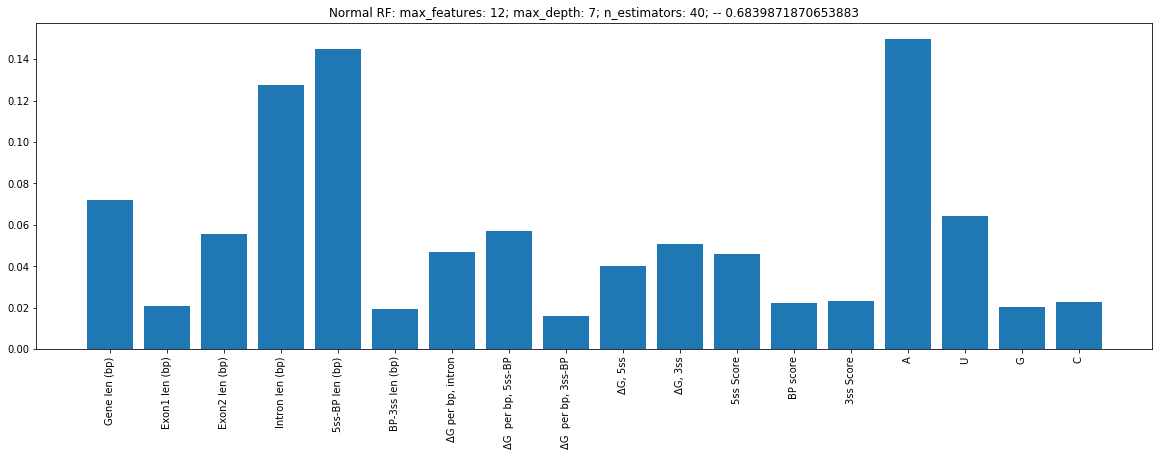

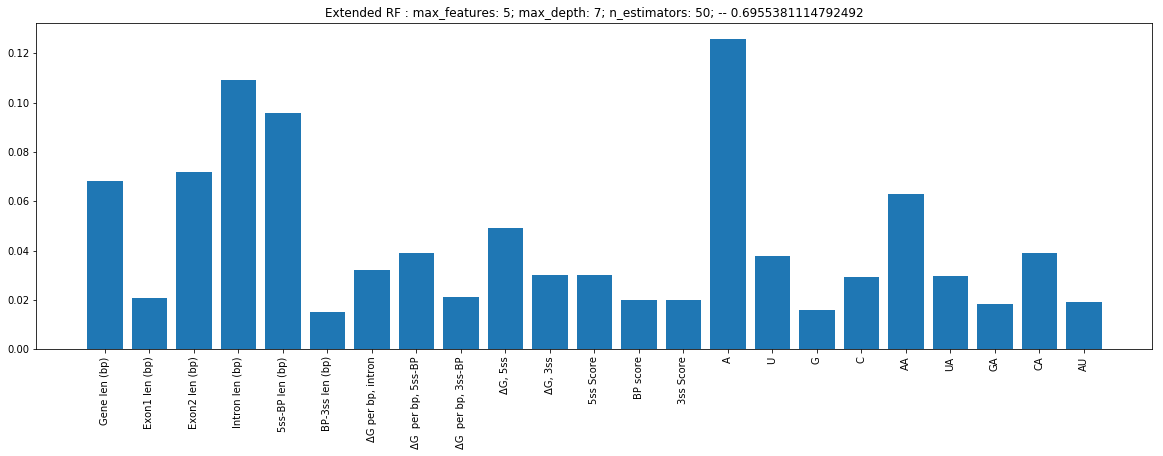

In [15]:
best_RFs(results_1_full,results_2_full,'full')

Data
Coefficient of determination R^2: 0.4088825365042926
Mean squared error:               0.030829573996841313
Mean absolute error:              0.13158937717690875
Root mean squared error:          0.1755835242750336
Correlation Coefficient:          0.656753357271128


Extended Data
Coefficient of determination R^2: 0.41094146679533605
Mean squared error:               0.030722191035447002
Mean absolute error:              0.13179640788224123
Root mean squared error:          0.17527746870447156
Correlation Coefficient:          0.6469918336286259


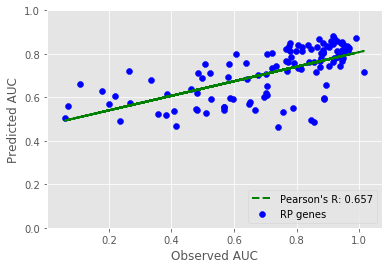

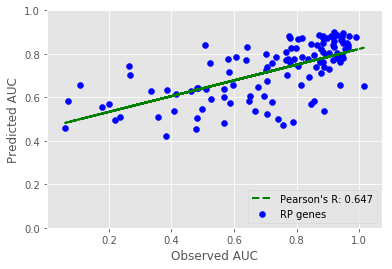

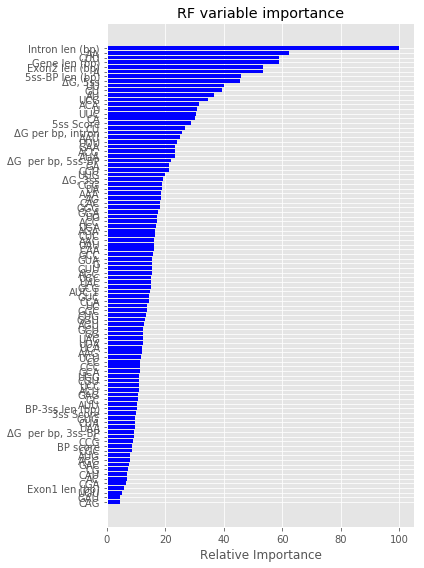

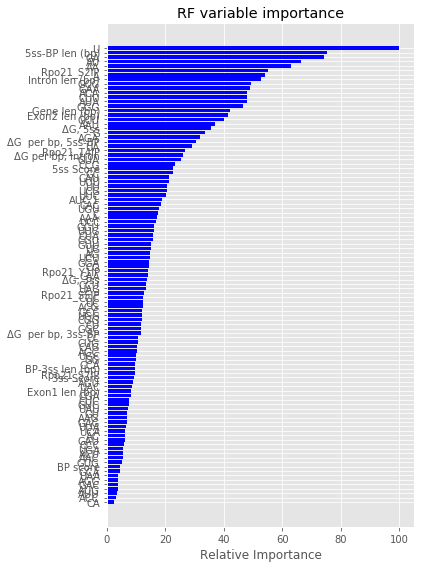

In [28]:
#BEST FULL

# Normal best: 0.656753357271128 | max_features: 12; max_depth: 12; n_estimators: 40;
# Extended best: 0.6469918336286258 | max_features: 20; max_depth: 18; n_estimators: 20;

X,y,X2,y2 = get_data('full')

rfr1 = ExtraTreesRegressor(n_estimators=40, 
                            criterion='mse', 
                            max_features=12, 
                            max_depth=12, 
                            n_jobs=2,
                            random_state=1337)

rfr2 = ExtraTreesRegressor(n_estimators=20, 
                            criterion='mse', 
                            max_features=20, 
                            max_depth=18, 
                            n_jobs=2,
                            random_state=1337)

kf = KFold(n_splits=5,shuffle=True,random_state=0)
predictions_rfr1 = cross_val_predict(rfr1,X,y=y,cv=kf)
predictions_rfr2 = cross_val_predict(rfr2,X2,y=y2,cv=kf)

fit_scatter(y,predictions_rfr1)
fit_scatter(y,predictions_rfr2)
print('Data')
print_stats(y,predictions_rfr1)
print('\n')
print('Extended Data')
print_stats(y2,predictions_rfr2)

rfr1.fit(X,y)
rfr2.fit(X2,y2)

names,names2 = get_variable_names('full')
plot_importance(rfr1.feature_importances_,names,'full')
plot_importance(rfr2.feature_importances_,names2,'full_ext')


## MSE Results

Normal best: 0.6839871870653883 | max_features: 12; max_depth: 7; n_estimators: 40;

Extended best: 0.695538111479249 | max_features: 5; max_depth: 7; n_estimators: 50;

Best difference: 0.08235234031060501 | max_features: 12; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.46275664633060276
Mean squared error:               0.02801978413615613
Mean absolute error:              0.1249529426526229
Root mean squared error:          0.16739111128180054
Correlation Coefficient:          0.6839871870653883


Extended feature space
Coefficient of determination R^2: 0.46177284867054846
Mean squared error:               0.028071093841302037
Mean absolute error:              0.12581442108330093
Root mean squared error:          0.1675443041147685
Correlation Coefficient:          0.6955381114792492


# RP Genes

In [ ]:
X,y,X2,y2 = get_data('rp_full')

mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
md = [5,7,10,12,15,18,20]
n_est = [10,20,30,40,50,60,80,90,100,120,140,160]

results_1_rp = np.zeros((len(mxf),len(md),len(n_est)))
results_2_rp = np.zeros((len(mxf),len(md),len(n_est)))

f = FloatProgress(min=0, max=(len(mxf)*len(md)*len(n_est)))
display(f)


i = 0
for max_features in mxf:
    j = 0
    for max_depth in md:
        k = 0
        for n_estimators in n_est:            
            
            kf = KFold(n_splits=5,shuffle=True,random_state=0)

            rfr1 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            rfr2 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            predictions_rfr1 = cross_val_predict(rfr1,X=X,y=y,cv=kf)
            predictions_rfr2 = cross_val_predict(rfr2,X=X2,y=y2,cv=kf)
            
            print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

            print('Normal feature space')
            print_stats(y, predictions_rfr1)
            print('\n')
            print('Extended feature space')
            print_stats(y2, predictions_rfr2)
            print('-------------------------------------------------------\n')
            

            results_1_rp[i][j][k]=np.corrcoef(y, predictions_rfr1)[0][1]
            results_2_rp[i][j][k]=np.corrcoef(y2, predictions_rfr2)[0][1]
            
            f.value += 1
            
            k += 1
        j += 1
    i += 1

FloatProgress(value=0.0, max=1008.0)

max_features: 5; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2200662646993855
Mean squared error:               0.02310306302833034
Mean absolute error:              0.10516115559292183
Root mean squared error:          0.15199691782510047
Correlation Coefficient:          0.47707155767221454


Extended feature space
Coefficient of determination R^2: 0.255714399876972
Mean squared error:               0.022047100096386153
Mean absolute error:              0.10769537900084443
Root mean squared error:          0.14848265924472848
Correlation Coefficient:          0.5259759532794929
-------------------------------------------------------

max_features: 5; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2698798386815092
Mean squared error:               0.02162749390330484
Mean absolute error:              0.10279348167738833
Root mean squared error:          0.14706289097969222
Correlation Coefficient:

KeyboardInterrupt: 

In [99]:
get_best_settings(results_1_rp,results_2_rp)

NameError: name 'results_1_rp' is not defined

In [100]:
best_RFs(results_1_rp,results_2_rp,'rp')

NameError: name 'best_RFs' is not defined

Data
Coefficient of determination R^2: 0.30689238223978865
Mean squared error:               0.020531114700863794
Mean absolute error:              0.09984394095554236
Root mean squared error:          0.14328682668292922
Correlation Coefficient:          0.668615198500886


Extended Data
Coefficient of determination R^2: 0.2917181238299157
Mean squared error:               0.02098060397486775
Mean absolute error:              0.1054363756613757
Root mean squared error:          0.14484682935731713
Correlation Coefficient:          0.6115140633294025


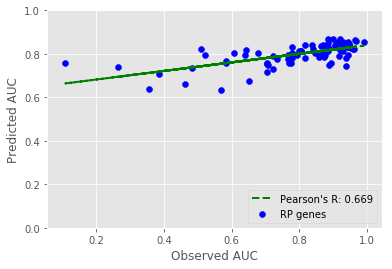

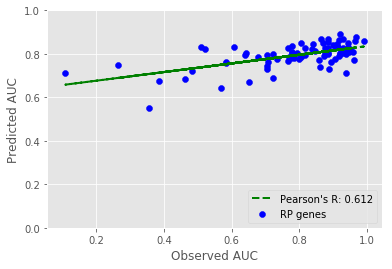

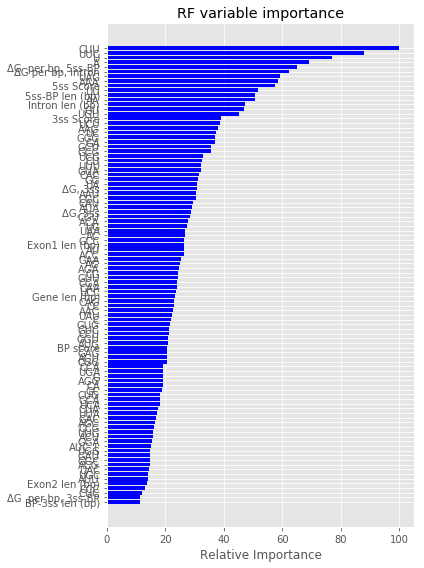

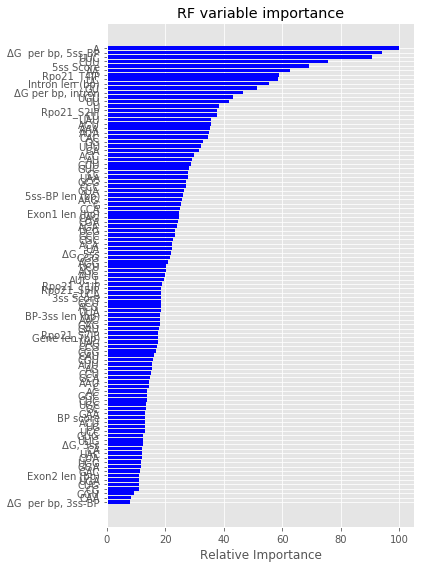

In [29]:
#BEST RIBOSOMAL PROTEIN

# Normal best: 0.6686151985008865 | max_features: 5; max_depth: 12; n_estimators: 140;
# Extended best: 0.6750835594373263 | max_features: 18; max_depth: 18; n_estimators: 90;
                
X,y,X2,y2 = get_data('rp')

rfr1 = ExtraTreesRegressor(n_estimators=140, 
                            criterion='mse', 
                            max_features=5, 
                            max_depth=12, 
                            n_jobs=2,
                            random_state=1337)

rfr2 = ExtraTreesRegressor(n_estimators=90, 
                            criterion='mse', 
                            max_features=5, 
                            max_depth=18, 
                            n_jobs=2,
                            random_state=1337)

kf = KFold(n_splits=5,shuffle=True,random_state=0)
predictions_rfr1_rp = cross_val_predict(rfr1,X,y=y,cv=kf)
predictions_rfr2_rp = cross_val_predict(rfr2,X2,y=y2,cv=kf)

fit_scatter(y,predictions_rfr1_rp)
fit_scatter(y,predictions_rfr2_rp)

print('Data')
print_stats(y,predictions_rfr1_rp)
print('\n')
print('Extended Data')
print_stats(y2,predictions_rfr2_rp)

rfr1.fit(X,y)
rfr2.fit(X2,y2)

names,names2 = get_variable_names('full')
plot_importance(rfr1.feature_importances_,names,'rp_full')
plot_importance(rfr2.feature_importances_,names2,'rp_full_extended')

Normal best: 0.683828520812472 | max_features: 80; max_depth: 12; n_estimators: 10;
Extended best: 0.6995253307038448 | max_features: 25; max_depth: 5; n_estimators: 10;
Best difference: 0.178522036722764 | max_features: 7; max_depth: 5; n_estimators: 20;
Normal feature space
Coefficient of determination R^2: 0.3526340326994295
Mean squared error:               0.03376319974358975
Mean absolute error:              0.13876153846153846
Root mean squared error:          0.18374765234851234
Correlation Coefficient:          0.5972822538667238


Extended feature space
Coefficient of determination R^2: 0.32708078033033505
Mean squared error:               0.03509592282051282
Mean absolute error:              0.14166068376068375
Root mean squared error:          0.18733905844887985
Correlation Coefficient:          0.5756356719726347

# Non-RP Genes

In [ ]:
X,y,X2,y2 = get_data('nrp_full')

mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
md = [5,7,10,12,15,18,20]
n_est = [10,20,30,40,50,60,80,90,100,120,140,160]

results_1_nrp = np.zeros((len(mxf),len(md),len(n_est)))
results_2_nrp = np.zeros((len(mxf),len(md),len(n_est)))

f = FloatProgress(min=0, max=(len(mxf)*len(md)*len(n_est)))
display(f)


i = 0
for max_features in mxf:
    j = 0
    for max_depth in md:
        k = 0
        for n_estimators in n_est:            
            
            kf = KFold(n_splits=5,shuffle=True,random_state=0)

            rfr1 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            rfr2 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            predictions_rfr1 = cross_val_predict(rfr1,X=X,y=y,cv=kf)
            predictions_rfr2 = cross_val_predict(rfr2,X=X2,y=y2,cv=kf)
            
            print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

            print('Normal feature space')
            print_stats(y, predictions_rfr1)
            print('\n')
            print('Extended feature space')
            print_stats(y2, predictions_rfr2)
            print('-------------------------------------------------------\n')
            

            results_1_nrp[i][j][k]=np.corrcoef(y, predictions_rfr1)[0][1]
            results_2_nrp[i][j][k]=np.corrcoef(y2, predictions_rfr2)[0][1]
            
            f.value += 1
            
            k += 1
        j += 1
    i += 1

In [22]:
get_best_settings(results_1_nrp,results_2_nrp)

Normal best: 0.4827552257052628 | max_features: 18; max_depth: 15; n_estimators: 10;
Extended best: 0.4325119102278271 | max_features: 18; max_depth: 7; n_estimators: 20;
Best difference: 0.11544214057611918 | max_features: 7; max_depth: 7; n_estimators: 10;


(18, 15, 10, 18, 7, 20)

In [45]:
best_RFs(results_1_nrp,results_2_nrp,'nrp_full')

NameError: name 'best_RFs' is not defined

Data
Coefficient of determination R^2: 0.022805336002514442
Mean squared error:               0.05716727691395379
Mean absolute error:              0.18778772224408588
Root mean squared error:          0.239096794026925
Correlation Coefficient:          0.24154891704945836


Extended Data
Coefficient of determination R^2: -0.09856643296740364
Mean squared error:               0.06426769792715899
Mean absolute error:              0.21479593984397458
Root mean squared error:          0.2535107451907295
Correlation Coefficient:          0.03403709874447883


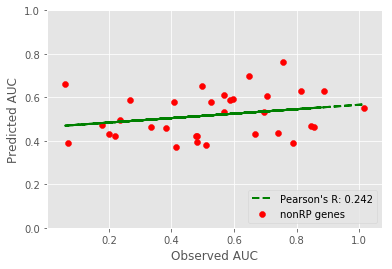

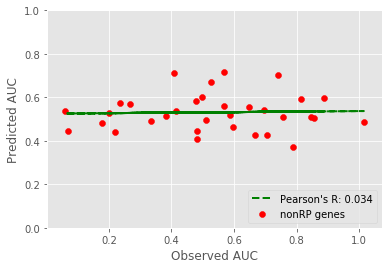

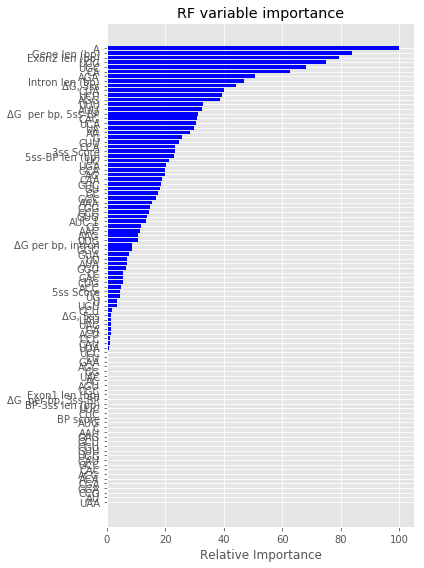

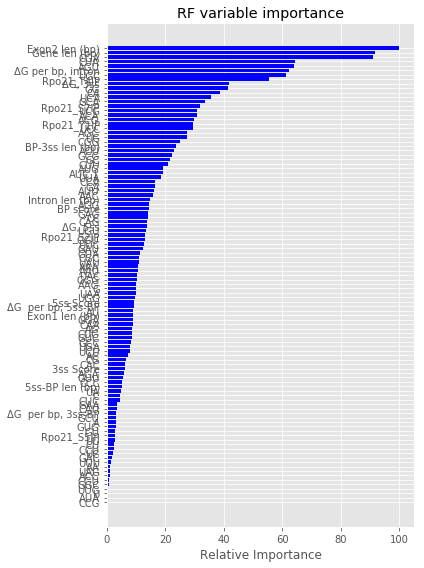

In [31]:
#BEST RIBOSOMAL PROTEIN

# Normal best: 0.2969901764177368 | max_features: 25; max_depth: 5; n_estimators: 10;
# Extended best: 0.40630448232918154 | max_features: 30; max_depth: 7; n_estimators: 20;

X,y,X2,y2 = get_data('nrp')

rfr1 = ExtraTreesRegressor(n_estimators=10, 
                            criterion='mse', 
                            max_features=25, 
                            max_depth=5, 
                            n_jobs=2,
                            random_state=1337)

rfr2 = ExtraTreesRegressor(n_estimators=20, 
                            criterion='mse', 
                            max_features=30, 
                            max_depth=7, 
                            n_jobs=2,
                            random_state=1337)

kf = KFold(n_splits=5,shuffle=True,random_state=0)
predictions_rfr1_nrp = cross_val_predict(rfr1,X,y=y,cv=kf)
predictions_rfr2_nrp = cross_val_predict(rfr2,X2,y=y2,cv=kf)

fit_scatter_nrp(y,predictions_rfr1_nrp)
fit_scatter_nrp(y,predictions_rfr2_nrp)

print('Data')
print_stats(y,predictions_rfr1_nrp)
print('\n')
print('Extended Data')
print_stats(y2,predictions_rfr2_nrp)

rfr1.fit(X,y)
rfr2.fit(X2,y2)

names,names2 = get_variable_names('full')
plot_importance(rfr1.feature_importances_,names,'nrp_full')
plot_importance(rfr2.feature_importances_,names2,'nrp_full_ext')

Normal best: 0.2969901764177368 | max_features: 25; max_depth: 5; n_estimators: 10;
Extended best: 0.40630448232918154 | max_features: 30; max_depth: 7; n_estimators: 20;
Best difference: 0.2582434619528223 | max_features: 30; max_depth: 7; n_estimators: 20;
Normal feature space
Coefficient of determination R^2: 0.2360352774266372
Mean squared error:               0.03984437679487179
Mean absolute error:              0.1488410256410256
Root mean squared error:          0.19961056283391365
Correlation Coefficient:          0.48848065665874996


Extended feature space
Coefficient of determination R^2: 0.38909635792549957
Mean squared error:               0.031861516874999996
Mean absolute error:              0.13109380341880345
Root mean squared error:          0.1784979464167585
Correlation Coefficient:          0.6250700537546936

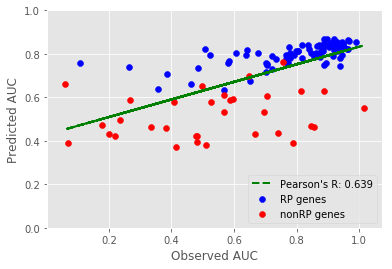

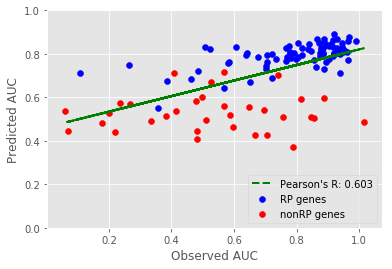

In [32]:
X,y1,_,_ = get_data('rp')
X,y2,_,_ = get_data('nrp')

fit_scatter_multi(y1,y2,predictions_rfr1_rp,predictions_rfr1_nrp,'full_rp_nrp')
fit_scatter_multi(y1,y2,predictions_rfr2_rp,predictions_rfr2_nrp,'full_rp_nrp_ext')

In [26]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict

X,Y,X2,Y2 = get_data('full')
names = gene_features.drop(['ORG','Gene','AUC'], axis=1).columns
rf = RandomForestRegressor(random_state=1337,n_estimators=300)
scores = defaultdict(list)
X = X.values
Y = Y.values
#crossvalidate the scores on a number of different random splits of the data
for train_idx, test_idx in ShuffleSplit(len(X), 100, .3):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    r = rf.fit(X_train, Y_train)
    acc = r2_score(Y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(Y_test, rf.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)
print("Features sorted by their score:")
print (sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))

Features sorted by their score:
[(0.6054, 'A'), (0.2064, 'U'), (0.085, 'ΔG, 5ss'), (0.0845, '5ss-BP len (bp)'), (0.0708, 'Exon2 len (bp)'), (0.0685, 'Intron len (bp)'), (0.0233, 'G'), (0.018, 'ΔG per bp, intron'), (0.0176, 'BP-3ss len (bp)'), (0.0081, 'ΔG, 3ss'), (0.0081, 'Gene len (bp)'), (-0.003, 'C'), (-0.0033, 'ΔG  per bp, 3ss-BP'), (-0.0056, 'BP score'), (-0.0077, 'Exon1 len (bp)'), (-0.0102, '3ss Score'), (-0.0129, 'ΔG  per bp, 5ss-BP'), (-0.0159, '5ss Score')]


MSE: 0.0391
R2: -2.0055


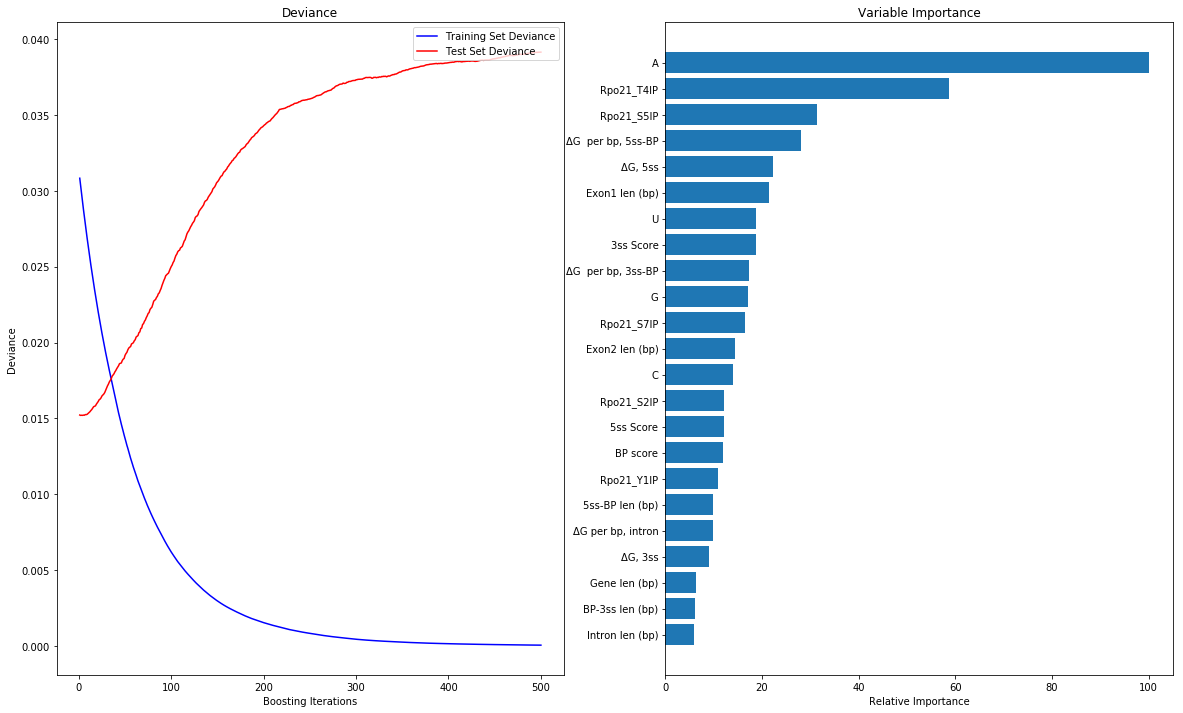

In [41]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
# Load data
names = extended_features_cut.drop(['ORG','Gene','AUC'], axis=1).columns
X2,y2,X,y = get_data('rp_cut')
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)
print("R2: %.4f" % r2_score(y_test,clf.predict(X_test)))

# #############################################################################
# Plot training deviance

# # compute test set deviance
# test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

# for i, y_pred in enumerate(clf.staged_predict(X_test)):
#     test_score[i] = clf.loss_(y_test, y_pred)


# plt.subplot(1, 2, 1)
# plt.title('Deviance')
# plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
#          label='Training Set Deviance')
# plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
#          label='Test Set Deviance')
# plt.legend(loc='upper right')
# plt.xlabel('Boosting Iterations')
# plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
plt.figure(figsize=(20, 12))
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
